# 1. Project LIDA

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, Azure OpenAI, PaLM, Cohere, Huggingface).Details on the components of LIDA are described in [this paper](https://arxiv.org/abs/2303.02927) - star [this project](https://aka.ms/lida/github) for updates. 

LIDA _treats visualizations as code_ and provides a clean api for generating, executing, editing, explaining, evaluating and repairing visualization code. Here are some tasks you can execute with LIDA.

- ✅ Data Summarization
- ✅ Goal Generation
- ✅ Visualization Generation
- ⬜️ Visualization Editing
- ✅ Visualization Explanation
- ⬜️ Visualization Evaluation and Repair
- ✅ Visualization Recommendation
- ⬜️ Infographic Generation (beta) # pip install lida[infographics]

![LIDA Modules illustrated](https://github.com/microsoft/lida/raw/main/docs/images/lidamodules.jpg)

## 1. Data Summarization
Given a dataset, generate a compact summary of that data in a compact natural language representation that serves as context for subsequent tasks. The goal of the summarizer is to _produce an dense-but-compact information summary for a given dataset that is useful as grounding context for visualization tasks_. The grounding context is defined as one that contains information an analyst would need to understand the dataset and the tasks that can be performed on it.

See [paper](https://arxiv.org/pdf/2303.02927.pdf) for details

In [1]:
# Setup
from lida import Manager, TextGenerationConfig , llm  

csvfile = "./../../data/kaggle/IPL-2022.csv"
lida = Manager(text_gen = llm("openai")) # palm, cohere .
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

In [2]:
# Summarize
summary = lida.summarize(csvfile)
summary_data = list(summary.keys())
for keys in summary_data:
    print(keys, ":", summary[keys])

name : IPL-2022.csv
file_name : IPL-2022.csv
dataset_description : 
fields : [{'column': 'match_id', 'properties': {'dtype': 'number', 'std': 21, 'min': 1, 'max': 74, 'samples': [5, 64, 19], 'num_unique_values': 74, 'semantic_type': '', 'description': ''}}, {'column': 'date', 'properties': {'dtype': 'string', 'samples': ['May 15,2022', 'May 21,2022', 'March 26,2022'], 'num_unique_values': 62, 'semantic_type': '', 'description': ''}}, {'column': 'venue', 'properties': {'dtype': 'category', 'samples': ['Wankhede Stadium, Mumbai', 'Brabourne Stadium, Mumbai', 'Narendra Modi Stadium, Ahmedabad'], 'num_unique_values': 6, 'semantic_type': '', 'description': ''}}, {'column': 'team1', 'properties': {'dtype': 'category', 'samples': ['Lucknow', 'Delhi', 'Kolkata'], 'num_unique_values': 9, 'semantic_type': '', 'description': ''}}, {'column': 'team2', 'properties': {'dtype': 'category', 'samples': ['Chennai', 'Mumbai', 'Gujarat'], 'num_unique_values': 9, 'semantic_type': '', 'description': ''}}, {

## 2. Goal Generation

Given the dataset "context" generated by the summarizer, the LLM must now _generate a question (hypothesis), a visualization (that addresses the question) and a rationale (for that visualization)_. The research found that requiring the LLM to produce a rationale led to more semantically meaningful goals.

The generation API takes these parameters - the summary, the number of goals to generate (n) and a persona (optional) that influences the tone or context for the goals generated. And the textgen_config that configures parameters for the given model.

See [paper](https://arxiv.org/pdf/2303.02927.pdf) for details

In [3]:
# generate 5 goals from the summary - with the persona is a fan of the Mumbai team
goals = lida.goals(summary, n=5, textgen_config=textgen_config, persona="fam of the Mumbai team who wants to see their stats") # exploratory data analysis

# create a list of dictionaries containing the goal information
import pandas as pd
goal_list = []
for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of venues for Mumbai team matches?

**Visualization:** `Bar chart of venue vs count of matches where team1 or team2 is Mumbai`

**Rationale:** This visualization will show the frequency of matches played by Mumbai team at different venues. This will help the persona understand which venues are most favorable for the team and which are not.



### Goal 1
---
**Question:** What is the average score of Mumbai team in the first innings?

**Visualization:** `Box plot of first_ings_score for matches where team1 or team2 is Mumbai`

**Rationale:** This visualization will show the median and spread of the first innings score for Mumbai team matches. This will help the persona understand the typical performance of the team in the first innings.



### Goal 2
---
**Question:** What is the correlation between first innings score and match winner?

**Visualization:** `Scatter plot of first_ings_score vs match_winner for matches where team1 or team2 is Mumbai`

**Rationale:** This visualization will show the relationship between the first innings score and the match winner for Mumbai team matches. This will help the persona understand how important a good first innings score is for winning matches.



### Goal 3
---
**Question:** What is the distribution of margins of victory for Mumbai team matches?

**Visualization:** `Histogram of margin for matches where team1 or team2 is Mumbai`

**Rationale:** This visualization will show the frequency of different margins of victory for Mumbai team matches. This will help the persona understand how often the team wins by a large margin and how often they win by a small margin.



### Goal 4
---
**Question:** What is the performance of Mumbai team against different opponents?

**Visualization:** `Stacked bar chart of team1 or team2 vs count of matches won or lost by Mumbai team`

**Rationale:** This visualization will show the number of matches won and lost by Mumbai team against different opponents. This will help the persona understand which opponents are the toughest for the team and which opponents they perform well against.


In [4]:

# generate 10 goals from the summary with default persona
goals = lida.goals(summary, n=10, textgen_config=textgen_config,) # exploratory data analysis

# create a list of dictionaries containing the goal information
import pandas as pd
goal_list = []
for goal in goals:
    goal_dict = {'Question': goal.question, 'Visualization': goal.visualization, 'Rationale': goal.rationale}
    goal_list.append(goal_dict)
df = pd.DataFrame(goal_list)
display(df)

,Question,Visualization,Rationale
0,What is the distribution of first innings scores?,Histogram of first_ings_score,This visualization will show the frequency of ...
1,What is the distribution of second innings sco...,Histogram of second_ings_score,This visualization will show the frequency of ...
2,What is the relationship between first innings...,Box plot of first_ings_score grouped by match_...,This visualization will show us the distributi...
3,What is the relationship between second inning...,Box plot of second_ings_score grouped by match...,This visualization will show us the distributi...
4,What is the frequency of toss decisions?,Bar chart of toss_decision,This visualization will show us the number of ...
5,What is the distribution of winning margins?,Histogram of margin,This visualization will show the frequency of ...
6,What is the distribution of player of the matc...,Bar chart of player_of_the_match,This visualization will show us which players ...
7,What is the distribution of top scorers?,Bar chart of top_scorer,This visualization will show us which players ...
8,What is the distribution of best bowling figures?,Bar chart of best_bowling_figure,This visualization will show us which bowlers ...
9,What is the relationship between first innings...,Scatter plot of first_ings_score and best_bowl...,This visualization will help us understand if ...


## 3. Visualization Generation

Charts length: 1


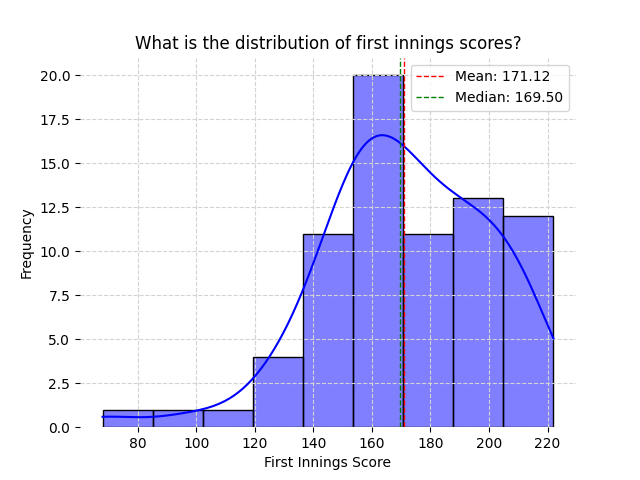

In [5]:
# Visualize A Goal 
charts = lida.visualize(summary=summary, goal=goals[0]) # exploratory data analysis
print("Charts length:", len(charts))
charts[0]

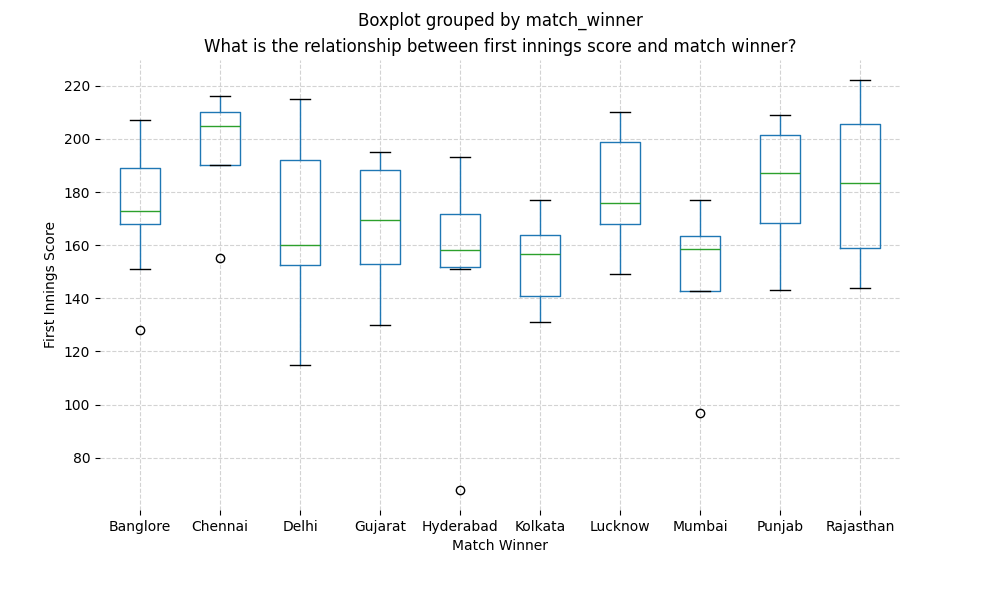

In [6]:
# Visualize a Goal - and specify a library
target = goals[2]
library = "matplotlib"
charts = lida.visualize(summary=summary, goal=target, library=library) # exploratory data analysis
charts[0]

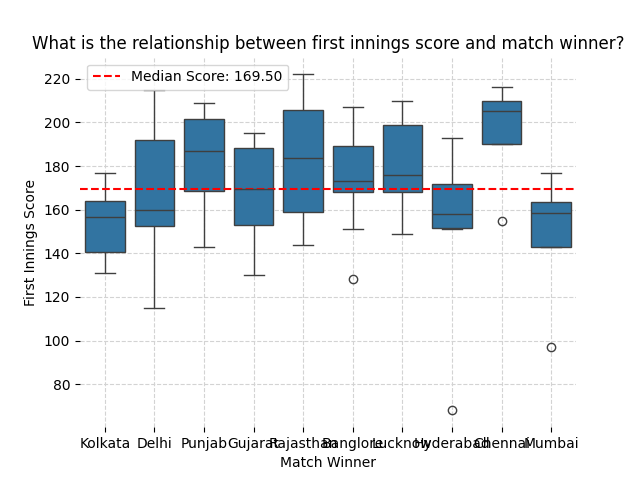

In [7]:
# Visualize it again - and specify a different library and textgen_config (change temperature)
target = goals[2]
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=target,library=library,textgen_config=textgen_config) # exploratory data analysis
charts[0]

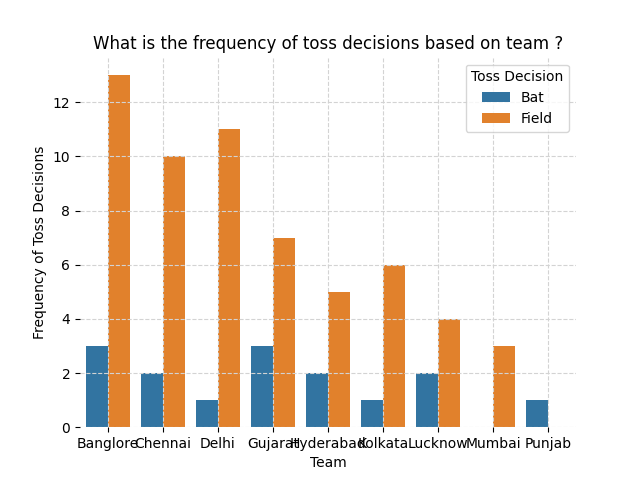

In [10]:
# Use natural language user query instead of pre-formulated goal
user_query = "What is the frequency of toss decisions based on team ?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

## 4. Visualization Explanation

In [30]:
# Explain visualization
explanation = lida.explain(code=charts[0].code)
for obj in explanation[0]:
    display(obj)


{'section': 'accessibility',
 'code': 'None',
 'explanation': 'The plot function creates a bar chart using the seaborn library to visualize the frequency of toss decisions based on team. The chart has two variables on the x-axis and y-axis respectively, with the hue variable represented by different colors. The goal of the chart is to show the distribution of toss decisions across different teams and to identify any patterns or trends in the data. The chart is easy to read and understand, with clear labels and a legend to help interpret the data.'}

{'section': 'transformation',
 'code': "grouped_data = data.groupby(['team1', 'toss_decision']).size().reset_index(name='count')",
 'explanation': "This section of the code applies data transformation by grouping the data by team1 and toss_decision columns and then counting the frequency of each combination using the size() method. The reset_index() method is then used to convert the resulting series object into a dataframe with a new column named 'count'. This transformation is necessary to aggregate the data and prepare it for visualization."}

{'section': 'visualization',
 'code': "sns.barplot(x='team1', y='count', hue='toss_decision', data=grouped_data)\nplt.xlabel('Team')\nplt.ylabel('Frequency of Toss Decisions')\nplt.title('What is the frequency of toss decisions based on team ?')\nplt.legend(title='Toss Decision', loc='upper right')",
 'explanation': 'This section of the code creates the visualization by calling the seaborn barplot() function and passing in the necessary parameters. The x-axis represents the team1 column, the y-axis represents the count column, and the hue variable represents the toss_decision column. The xlabel(), ylabel(), and title() methods are used to add labels to the chart, while the legend() method is used to add a legend with a title and location. This code generates a bar chart that shows the frequency of toss decisions based on team.'}

In [ ]:
# Edit visualization - modify using natural language -- insufficient tokens in model to run this
#instructions = ["change the color to green", "translate the title to french"]
# edited_charts = lida.edit(code=charts[0],  summary=summary, instructions=instructions)

## 5. Visualization Recommendation

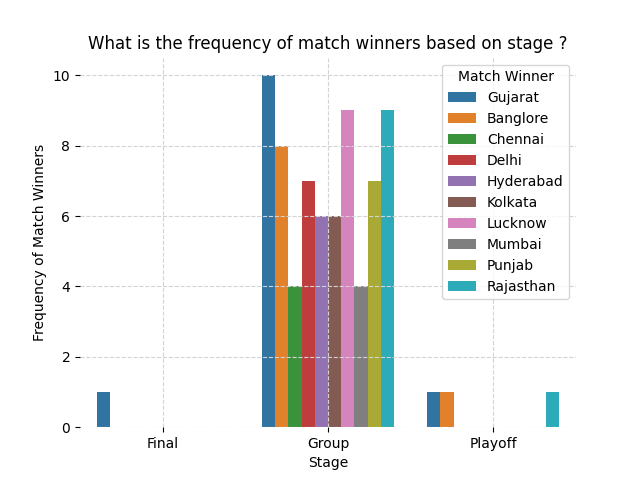

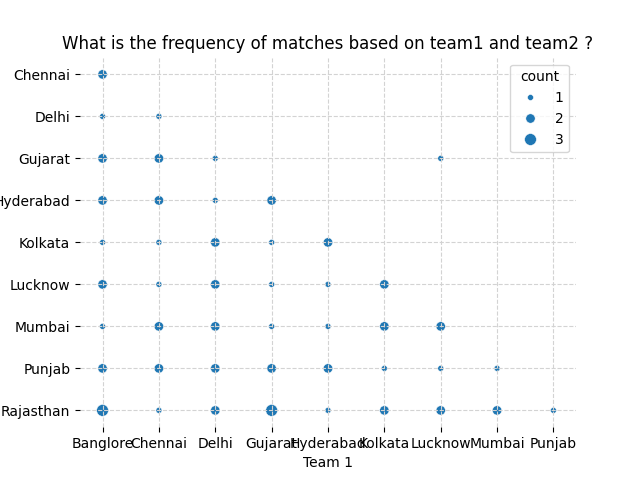

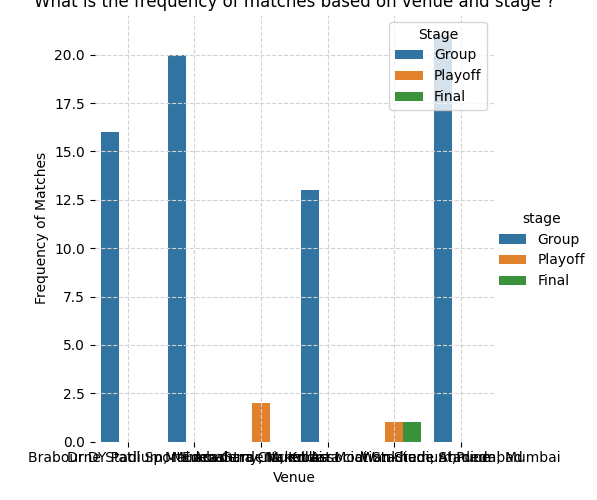

In [33]:
# Recommend 3 visualizations 
recommendations = lida.recommend(code=charts[0].code, summary=summary, n=3,  textgen_config=textgen_config)

for chart in recommendations:
    display(chart) 

<string>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


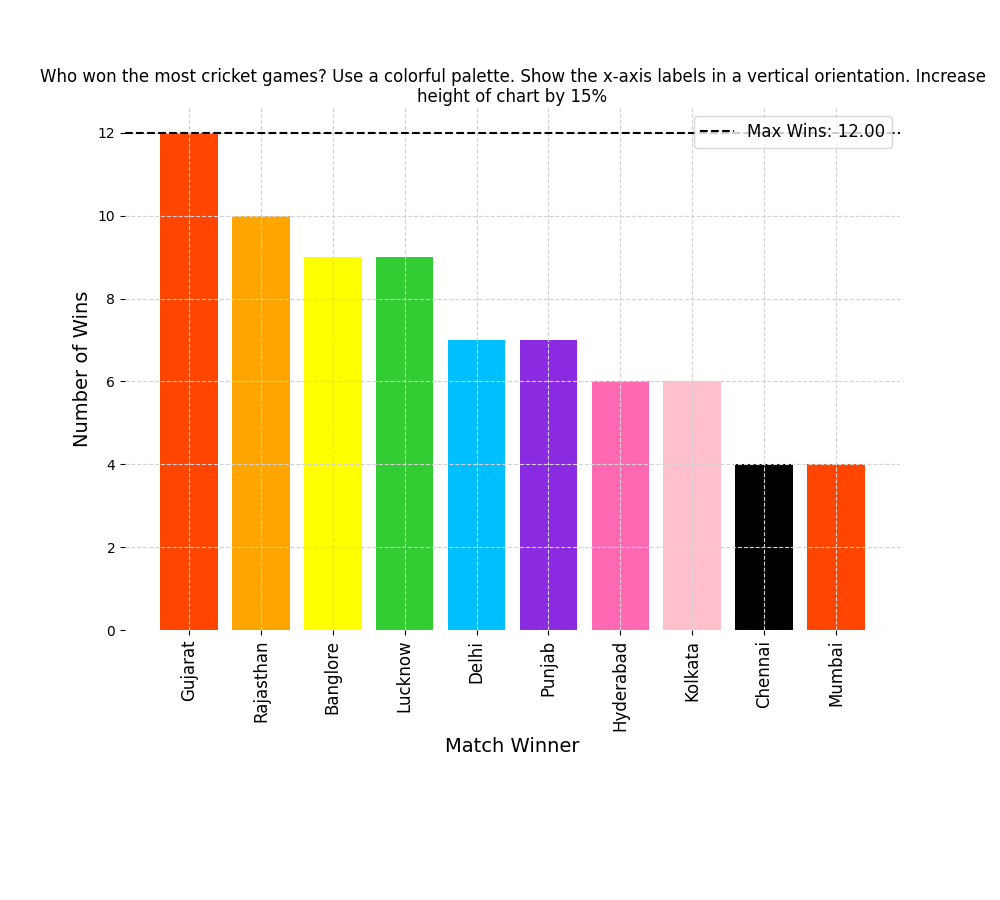

In [44]:
user_query = "Who won the most cricket games? Use a colorful palette. Show the x-axis labels in a vertical orientation. Increase height of chart by 15%"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config, library="matplotlib")  
charts[0]